In [1]:
import numpy as np
import torch
from functorch import vmap, grad
from caustic.sources import Sersic
from caustic.lenses import SIE
from caustic.utils import get_meshgrid
import matplotlib.pyplot as plt

/home/alexandre/anaconda3/envs/caustic/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Sketch

## Description

- User creates a class Pytorch style, where he creates the modules he/she needs (Source, Lens, etc.) in the ```__init__``` and the computational graph in the ```forward``` method.

- All **static parameters** are created and defined in ```__init__``` method, and the rest are left as **dynamic parameters** to be inferred.

- The Simulator class knows automatically the distinction by reading off the parameters from its modules.

### Static parameter
A parameter fixed during inference/simulation. For example, we might want to fix the cosmology unless we are doing time-delay cosmography. Then, $H_0$ will be considered a **static parameter**, or hyperparameter. 

In our context, a static parameter will simply be whatever needs to be defined in the ```__init___``` method.

### Dynamic parameter
A parameter that we wish to infer. The value of this parameter is not known in advance by our simulator (remains undefined in the ```__init__``` method). In other words, it will be part of the $\mathbf{x}$ tensor fed into the forward method of the simulator. 

### Sketch
```
class Sketch(Simulator):
    def __init__(self, **static_parameters, **hyperparameters, device=DEVICE):
        self.source = Sersic(**static_parameters, name="source", device=device)
        self.lens = SIE(**static_parameters, name="lens", device=device)
        self.instruments = Instruments(**static_parameters, name="instruments", device=DEVICE)
        
        self.cosmology = FlatLambdaCDM(**static_parameters)
        self.thx, self.thy = get_meshgrid(**hyperparameters)
        self.zl, self.zs = **hyperparameters
    
    def forward(x):
        x = self.transform_to_physical(x)
        ax, ay = self.lens.alpha(self.thx, self.thy, x["lens"])
        ax2, ay2 = self.lens2.alpha(self.thx, self.thy, x["lens2"])

        y = self.source.brightness(self.thx - ax, self.thy - ay, x["source"])
        y = self.instruments.observe(y, x["instruments"])
        return y
        
```

### What do we need to accomplish such a control flow?
- Every module need to know what their parameters are, as well as their numerical constraints. Thus we need 2 things
    1. Create a Parameter class
    2. Redefine the ```__init__``` of every module in a way to can catch static parameters, and leave undefined the dynamic parameters. 
- The Simulator module will need to know about its dynamic parameters so that the user can easily get access to the structure of $\mathbf{x}$.

## Single Parameter 

Properties of this class
- Has a state that tell us if the parameter is **static** or **dynamic**
- Has an **inherent dimensionality D**. For now, we only work with D=1. 
- Has a **name** for better readability, defined inside our code, not by user. 
- Has an **inherent transformation** from unconstrained (real) to constrained space. This is defined inside our code for numerical stability. 

In [2]:
import torch
from torch.distributions import transform_to, biject_to
from torch.distributions import constraints as C
from torch.distributions.constraints import Constraint
from torch.distributions.transforms import Transform

class IdentityTransform(Transform):
    domain = C.real
    codomain = C.real

    def __eq__(self, other):
        return isinstance(other, IdentityTransform)

    def _call(self, x):
        return x

    def _inverse(self, y):
        return y
    
    def log_abs_det_jacobian(self, x, y):
        return 0.


class Parameter:
    def __init__(
        self, 
        value: float, 
        default_value: float, 
        name: str, 
        index: int, 
        dimension: list, 
        transform: Transform,
        device=torch.device("cpu")):
        self._D = dimension
        self.name = name
        self.index = index
        self._default_value = torch.tensor([default_value]).to(device) # TODO do we keep this? What to do when deault is not just a float
        if value is None:
            self._dynamic = True
            self._value = None
        else:
            self._dynamic = False
            self._value = torch.tensor([value]).to(device)
        self.transform = transform

    
    @property
    def dynamic(self):
        return self._dynamic
    
    @dynamic.setter
    def dynamic(self):
        return self
    
    @property
    def D(self):
        return self._D
    
    @property
    def value(self):
        return self._value
    
    @value.setter
    def value(self, x):
        self.dynamic
    
    @property
    def default_value(self):
        return self._default_value

    def constrained_value(self, x):
        return self.transform(x)
    
    def unconstrained_value(self, x):
        return self.transform.inv(x)
    
    def log_abs_det_jacobian(self, x, y):
        return self.transform.log_abs_det_jacobian(x, y)
    
    def __repr__(self):
        return self.name


## List of parameters

This class is a useful way to collect all the parameters of a module, and define transformations from flattened tensor to list.

In [3]:
from pprint import pformat

# TODO setattr for each parameter names, so we can access them like p.x0 etc.
class ParameterList:  # this class will be used to store all parameters from a module
    def __init__(self, name, parameters=[]):
        self.name = name
        self.dynamic_parameters = []
        self.static_parameters = []
        self.transforms = []
        for p in parameters:
            if p.dynamic:
                self.dynamic_parameters.append(p)
                self.transforms.append(p.transform) # again, this assume D = 1 for all params. Will need to be more general. 
            else:
                self.static_parameters.append(p)
            self.__dict__[p.name] = p
        self._D = sum([np.prod(p.D) for p in self.dynamic_parameters])
        
    @property
    def D(self):
        return self._D
    
    def add(self, p):
        if p.dynamic:
            self._D += np.prod(p.D)
            self.dynamic_parameters.append(p)
            self.transforms.append(p.transform) # again, this assume D = 1 for all params. Will need to be more general. 
        else:
            self.static_parameters.append(p)
        self.__dict__[p.name] = p


    # This allows us to dynamically rearrenge the incoming tensor x, which is made up only of dynamic parameters, into a list of parameters that
    # can be interpreted by the module forward methods.
    def untangle_dynamic_tensor(self, x):
        assert x.shape[0] == len(self.dynamic_parameters) # for now, assume there is no batch dimensions. And assume D = 1 for all params. 
        D = len(self.dynamic_parameters)
        p = list(torch.tensor_split(x, D, dim=0) if D > 0 else []) + [p.value for p in self.static_parameters] # get all parameters in a list
        i_map = np.argsort([p.index for p in self.dynamic_parameters] + [p.index for p in self.static_parameters]) # get their order so that all methods of this class can work
        return [p[i] for i in i_map]
    
    def default(self):
        return torch.concat([p.default_value for p in self.dynamic_parameters])
    
    def unconstrained_default(self):
        return torch.concat([p.unconstrained_value(p.default_value) for p in self.dynamic_parameters])
    
    def constrained_values(self, x):
        x_prime = torch.clone(x) # Very important to clone here!! Otherwise transform will change the the value in memory, which is not good
        for d in range(self.D): # need to be more general than this
            x_prime[d] = self.transforms[d](x_prime[d])
        return x_prime
    
    def unconstrained_values(self, x):
        x_prime = torch.clone(x)
        for d in range(self.D): # need to be more general than this
            x_prime[d] = self.transforms[d].inv(x[d])
        return x_prime
    
    def log_abs_det_jacobian(self, x, y):
        jac = 0.
        for d, p in enumerate(self.dynamic_parameters): # need to be more general than this
            jac += p.log_abs_det_jacobian(x[d], y)
        return jac
    
    def __repr__(self):
        return pformat({self.name: {"Dynamic Parameters": self.dynamic_parameters, "Static Parameters": self.static_parameters}}, indent=2)

## Example of how we change a module 

2 things need to happen
- We give each module a **name**, which will help the simulator untangle the parameter space and give each their required parameters
- We attach to each module a **parameter list**, which help us take dynamic tensors and untangle them into all the parameter this class need to function. 

In [4]:
import torch
from torch.distributions import constraints as C
from torch.distributions import transforms as T

from caustic.utils import derotate, translate_rotate
from caustic.lenses.base import ThinLens

identity = torch.nn.Identity()


class SIE(ThinLens):
    """
    References:
        Keeton 2001, https://arxiv.org/abs/astro-ph/0102341
    """

    def __init__(self, name="sie", x0=None, y0=None, q=None, phi=None, b=None, s=0.0, device=torch.device("cpu")):
        super().__init__(device)
        self.name = name
        
        constraints = {"x0": C.real, "y0": C.real, "q": C.interval(0.05, 1), "phi": C.real, "b": C.positive, "s": C.positive}
        transforms = {"x0": IdentityTransform(), "y0": IdentityTransform(), "q": biject_to(C.interval(0.05, 1)), "phi": IdentityTransform(), 
                      "b": T.ExpTransform(), "s": T.SoftplusTransform()}
        defaults = {"x0": 0.0, "y0": 0.0, "q": 0.8, "phi": 0.0, "b": 1., "s": 0.0}
        self.parameters = ParameterList(name=name)
        for i, (k, p) in enumerate({"x0": x0, "y0": y0, "q": q, "phi": phi, "b": b, "s": s}.items()):
            self.parameters.add(Parameter(p, default_value=defaults[k], name=k, index=i, dimension=[1], transform=transforms[k], device=device))
        
    def _get_psi(self, x, y, q, s):
        return (q**2 * (x**2 + s**2) + y**2).sqrt()

    def alpha(self, thx, thy, z_l, z_s, cosmology, x):
        thx0, thy0, q, phi, b, s = self.parameters.untangle_dynamic_tensor(x)  # We infer the value of each parameter at inference time from static and dynamic lists.   
        thx, thy = translate_rotate(thx, thy, thx0, thy0, phi)
        psi = self._get_psi(thx, thy, q, s)
        f = (1 - q**2).sqrt()
        ax = b * q.sqrt() / f * (f * thx / (psi + s)).atan()
        ay = b * q.sqrt() / f * (f * thy / (psi + q**2 * s)).atanh()

        return derotate(ax, ay, phi)

    def Psi(self, thx, thy, z_l, z_s, cosmology, x):
        thx0, thy0, q, phi, b, s = self.untangle_dynamic_tensor(x)  # We infer the value of each parameter at inference time from static and dynamic lists.   
        thx, thy = translate_rotate(thx, thy, thx0, thy0, phi)
        # Only transform coordinates once: pass thx0=0, thy=0, phi=None to alpha
        ax, ay = self.alpha(thx, thy, z_l, z_s, cosmology, 0.0, 0.0, q, None, b, s)
        return thx * ax + thy * ay

    def kappa(self, thx, thy, z_l, z_s, cosmology, x):
        thx0, thy0, q, phi, b, s = self.untangle_dynamic_tensor(x)  # We infer the value of each parameter at inference time from static and dynamic lists.
        thx, thy = translate_rotate(thx, thy, thx0, thy0, phi)
        psi = self._get_psi(thx, thy, q, s)
        return 0.5 * q.sqrt() * b / psi


A cool thing about attaching parameters, is that they will function like a hook that we can search for later. 

In [5]:
# skecthing out how the hook will work
class Sketch1:
    def __init__(self):
        self.source = SIE()
sim = Sketch1()

# This loops accross attributes in search of the hook. This is the idea of how we will catch all parameters from the Simulator point of view, at inference time!
for module in [k for k, v in vars(sim).items() if not k.startswith('_')]:
    for m2 in [k for k,v in vars(getattr(sim, module)).items() if not k.startswith('_')]:
        if m2 == "parameters":
            print("I found the hook")

I found the hook


Static parameters will always be defined in the ```__init__```. All parameters with values in the ```__init__``` will automatically be labeled as **static**.

In [6]:
sie = SIE(x0=10.0) # Here we set x0 to be static
sie.parameters

{'sie': {'Dynamic Parameters': [y0, q, phi, b], 'Static Parameters': [x0, s]}}

In [7]:
sie = SIE(x0=10.0, y0=15.0) # We might want y0 to be static as well
sie.parameters

{'sie': {'Dynamic Parameters': [q, phi, b], 'Static Parameters': [x0, y0, s]}}

In [8]:
sie.parameters.default() # Default gives out a dynamic tensor filled with default values (defined internally)

tensor([0.8000, 0.0000, 1.0000])

In [9]:
# D is the shape of the dynamic tensor. Here, I show how the ParameterList can untangle a dynamic tensor into all parameters of the class
sie.parameters.untangle_dynamic_tensor(torch.arange(sie.parameters.D))

[tensor([10.]),
 tensor([15.]),
 tensor([0]),
 tensor([1]),
 tensor([2]),
 tensor([0.])]

In [10]:
from caustic.utils import to_elliptical, translate_rotate
from caustic.sources.base import Source


class Sersic(Source):
    
    def __init__(self, name="sersic", x0=None, y0=None, q=None, phi=None, index=None, r_eff=None, I_e=None, s=0.0, device=torch.device("cpu"), use_lenstronomy_k=False):
        """
        Args:
            lenstronomy_k_mode: set to `True` to calculate k in the Sersic exponential
                using the same formula as lenstronomy. Intended primarily for testing.
        """
        super().__init__(device)
        self.lenstronomy_k_mode = use_lenstronomy_k
        self.module = None # just create a hook to let Simulator know there are potentially dynamical parameters here. We might think of something better later
        self.name = name
        
        # Here we store the parameters. Then we can recover the named parameters (kwargs) from these two list at inference time
        self.parameters = ParameterList(name=name)
        constraints = {"x0": C.real, "y0": C.real, "q": C.interval(0.05, 1), 
                       "phi": C.real, "index": C.interval(0.2, 5), "r_eff": C.positive, "I_e": C.positive, "s": C.positive}
        transforms = {"x0": IdentityTransform(), "y0": IdentityTransform(), "q": biject_to(C.interval(0.05, 1)), 
                      "phi": IdentityTransform(), "index": biject_to(C.interval(0.2, 5)), "r_eff": T.SoftplusTransform(), 
                      "I_e": T.SoftplusTransform(), "s": T.SoftplusTransform()}
        defaults = {"x0": 0.0, "y0": 0.0, "q": 0.95, "phi": 0.0, "index": 1., "r_eff": 0.5, "I_e": 1., "s": 0.0}
        for i, (k, p) in enumerate({"x0": x0, "y0": y0, "q": q, "phi": phi, "index": index, "r_eff": r_eff, "I_e": I_e, "s": s}.items()):
            self.parameters.add(Parameter(p, default_value=defaults[k], name=k, index=i, dimension=[1], transform=transforms[k], device=device))

    def brightness(self, thx, thy, x):
        thx0, thy0, q, phi, index, th_e, I_e, s = self.parameters.untangle_dynamic_tensor(x)  # We infer the value of each parameter at inference time from static and dynamic lists.   
        thx, thy = translate_rotate(thx, thy, thx0, thy0, phi)
        ex, ey = to_elliptical(thx, thy, q)
        e = (ex**2 + ey**2).sqrt() + s

        if self.lenstronomy_k_mode:
            k = 1.9992 * index - 0.3271
        else:
            k = 2 * index - 1 / 3 + 4 / 405 / index + 46 / 25515 / index**2

        exponent = -k * ((e / th_e) ** (1 / index) - 1)
        return I_e * exponent.exp()

## Parameter collection for the simulator

We need yet another data structure at the Simulator level, since we are dealing with multiple modules.
This class will handle a collection of ParameterList. Its role is to
1. Take a dynamic tensor and split it into a dictionary labeled by the module names, which are also each ParameterList names. 
2. Be able to easily switch between data structure. Tensor, dictionary, list. (This will need the most thinking, since it interface directly 
    with the input of the forward method.)
   

In [11]:
from pprint import pformat

class ParameterCollection:  # this will be used to store a hierachy of parameters in the simulator
    def __init__(self, parameter_list, name="collection"):
        self.name = name
        self.parameters = [p for p in parameter_list] # Assume D is simply an integer.
        self._D = sum([p.D for p in parameter_list])
    
    def default(self):
        return torch.concat([p.default() for p in self.parameters if p.D > 0])
    
    def unconstrained_default(self):
        return torch.concat([p.unconstrained_default() for p in self.parameters if p.D > 0])
    
    def constrained_values(self, x):
        x_list = self.x_to_list(x)
        return torch.concat([p.constrained_values(_x) for p, _x in zip(self.parameters, x_list)])
    
    def unconstrained_values(self, x):
        x_list = self.x_to_list(x)
        return torch.concat([p.unconstrained_values(_x) for p, _x in zip(self.parameters, x_list)])
    
    def log_abs_det_jacobian(self, x, y):
        jac = 0.
        _D = 0
        for d, p in enumerate(self.parameters): # need to be more general than this
            jac += p.log_abs_det_jacobian(x[_D: _D + p.D], y)
            _D += p.D
        return jac
    
    @property
    def D(self):
        return self._D
        
    def x_to_list(self, x):
        d = 0
        x_list = []
        for p in self.parameters:
            x_list.append(x[d: p.D+d])
            d += p.D
        return x_list
    
    def x_to_dict(self, x):
        d = 0
        x_dict = {}
        for p in self.parameters:
            x_dict[p.name] = x[d: p.D+d]
            d += p.D
        return x_dict
    
    def __repr__(self): # might want to make this more precise, just did this as a catch all because this class is simple for now
        return pformat({self.name: {p.name: p.dynamic_parameters for p in self.parameters}}, indent=2)

## Example of a full simulator 

In [12]:
from caustic.cosmology import FlatLambdaCDM
from caustic.utils import get_meshgrid
from collections import OrderedDict

class Sketch2:
    # The user defines the init, so the particular structure here is just for demo. name and device should have class defaults
    def __init__(self, source_static_parameters={}, lens_static_parameters={}, name="sketch", device=torch.device("cpu")):
        self.source = Sersic(**source_static_parameters, name="source", device=device)
        self.lens = SIE(**lens_static_parameters, name="lens", device=device)

        self.cosmology = FlatLambdaCDM()
        self.thx, self.thy = get_meshgrid(0.1, 32, 32)
        self.zl, self.zs = 0.5, 1.5
        
        self.built = False # class property, we put it here for now to expose the logic
        self.name = name # class property

    def forward(self, x):
        x = self.parameters.constrained_values(x) # map from unconstrained space to physical space. We might leave this up to the user
        # Here, map from tensor to dictionary of module. Parameter has an internal logic to do this for now, but
        # we might want the simulator class to inherit that logic so it is more user friendly. Something like sim.x_to_dict etc.
        # Also, there might be cases where x is not strictly a tensor, but already a dictionary of params. 
        x = self.parameters.x_to_dict(x) 
        ax, ay = self.lens.alpha(self.thx, self.thy, self.zl, self.zs, self.cosmology, x["lens"])
        y = self.source.brightness(self.thx - ax, self.thy - ay, x["source"])
        return y
    
    # Class property
    @property
    def built(self):
        return self._built
    
    @built.setter
    def built(self, value: bool):
        assert isinstance(value, bool)
        self._built = value
    
    # Class property
    @property
    def parameters(self):
        if self.built:
            return self._parameters
        else:
            self.build()
            return self._parameters
    
    @parameters.setter
    def parameters(self, parameter_collection):
        assert isinstance(parameter_collection, ParameterCollection)
        self._parameters = parameter_collection
    
    # Class method, this is used by us to infer dynamically the graph of ops in forward.
    def build(self):
        # First, catch all modules of the init and their parameters collections
        params = []
        for module in [k for k, v in vars(self).items() if not k.startswith('_')]:
            try:
                for m2 in [k for k,v in vars(getattr(self, module)).items() if not k.startswith('_')]:
                    if m2 == "parameters": # hard coded hook
                        p = getattr(self, module).parameters
                        params.append(p)
            except TypeError:
                continue
        
        self.parameters = ParameterCollection(params, name=self.name)
        self.built = True


The parameters of the simulator are dynamically infered from the init method. At first, parameters is empty, so built is False

In [13]:
sim = Sketch2()
sim.built

False

But, the first time parameters is called, the simulator is built. We might want another trigger for it, to make sure we cover
all usecases. 

In [14]:
sim.parameters

{ 'sketch': { 'lens': [x0, y0, q, phi, b],
              'source': [x0, y0, q, phi, index, r_eff, I_e]}}

In [15]:
sim.built

True

We can create a default just like before, and send it to a list, one element for each 'modules' of the simulator 

In [16]:
sim.parameters.x_to_list(sim.parameters.default())

[tensor([0.0000, 0.0000, 0.9500, 0.0000, 1.0000, 0.5000, 1.0000]),
 tensor([0.0000, 0.0000, 0.8000, 0.0000, 1.0000])]

Or a dictionary, which exposes more clearly the semantic structure of the simulator. 

In [17]:
sim.parameters.x_to_dict(sim.parameters.default())

{'source': tensor([0.0000, 0.0000, 0.9500, 0.0000, 1.0000, 0.5000, 1.0000]),
 'lens': tensor([0.0000, 0.0000, 0.8000, 0.0000, 1.0000])}

We can also do optimization in the unconstrained space, and send these values to the constrained space just in time in the forward method with 
the ```constrained_values``` method

In [18]:
x = torch.randn(sim.parameters.D)
sim.parameters.constrained_values(x)

tensor([-1.5393,  0.0824,  0.0885,  0.2861,  2.7534,  0.1809,  0.6123,  1.4035,
        -0.5167,  0.7502, -1.2128,  2.0540])

# Inference

We now put everything together with an MCMC inference pipeline. 

## Uniform prior


The simplest case to cover is when we have a uniform prior over the parameter space. In this case, we only need to define a likelihood 
which we make gaussian 

$$p(\mathbf{y} | \mathbf{x}) = \mathcal{N}(\mathbf{y} | F(\mathbf{x}), \sigma_n \mathbb{1})$$

Then the posterior is simply proportional to the likelihood. 

For the case of simplicity, we will only infer the les parameters. This means that we must make the source parameters static. 

In [19]:
# First we create the simulator and fix all source parameters. It's quite important that nothing break, even though the dynamic tensor of the source module
# is empty
sim = Sketch2(
    source_static_parameters={
        "x0": 0.0,
        "y0": 0.0,
        "q": 0.8,
        "phi": 0.0,
        "index": 1.,
        "r_eff": 0.1,
        "I_e": 1.
    },
#     lens_static_parameters={
#         "x0": 0.0,
#         "y0": 0.0,
#         "q": 0.8,
#         "phi": 0.0,
#     }
)
# check that our simulator only has lens dynamic parameters. It should have an empty entry for the source
sim.parameters

{'sketch': {'lens': [x0, y0, q, phi, b], 'source': []}}

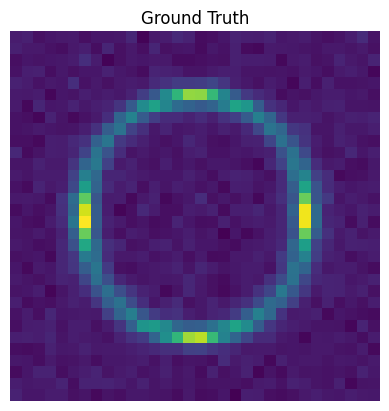

In [20]:
unconstrained_ground_truth = sim.parameters.unconstrained_default()
ground_truth = sim.parameters.default()

sigma_n = 0.1
y_true = sim.forward(unconstrained_ground_truth)
y_true += torch.randn_like(y_true) * sigma_n
plt.imshow(y_true.squeeze())
plt.axis("off")
plt.title("Ground Truth");

Now comes the inference part, we import MCMC from Octopus and infer what the dynamical parameters of the simulator should be

In [21]:
from octopus.score_samplers import Metropolis as MCMC

In [22]:
W = 300
N = 5000
epsilon = 1e-2

# We can start from wherever we like, since optimisation is in unconstrained space.
state = torch.randn((W, sim.parameters.D)) * 0.1

@vmap
def log_likelihood(z):
    y_hat = sim.forward(z)
    ll = -0.5 * torch.sum(torch.square(y_true - y_hat) / sigma_n**2)
    return ll + sim.parameters.log_abs_det_jacobian(z, ll)

sampler = MCMC(log_density_fn=log_likelihood, epsilon=epsilon)
posterior_samples, accepted = sampler.sample(state, N)

Average acceptance = 0.03: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:53<00:00, 93.67it/s]


In [23]:
constrained_posterior_samples = vmap(sim.parameters.constrained_values)(torch.tensor(posterior_samples).view(W * N, -1)).view(N, W, -1)

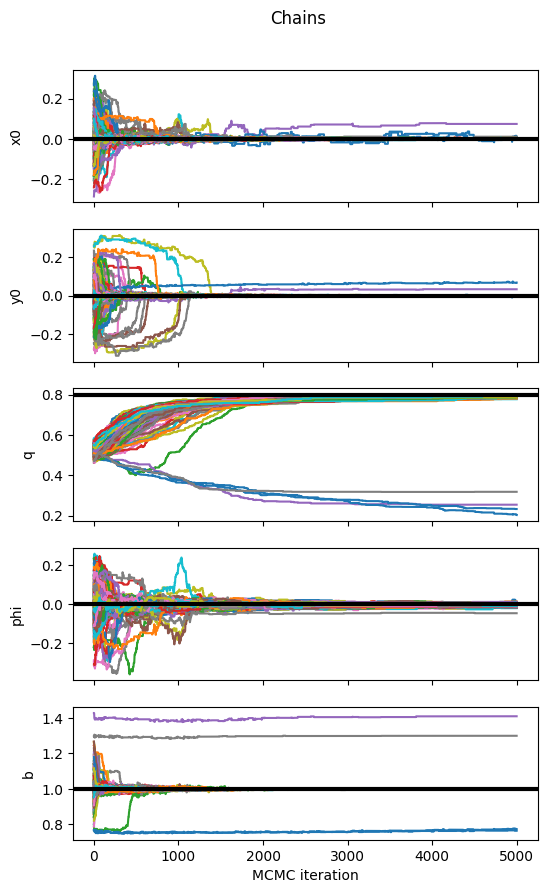

In [25]:
burn_in = 0

labels = ["x0", "y0", "q", "phi", "b"]

fig, axs = plt.subplots(5, 1, figsize=(6, 2*5), sharex=True)
for p in range(5):
    for worker in range(posterior_samples.shape[1]):
        param = constrained_posterior_samples[burn_in:, worker, p]
        axs[p].plot(param);
    axs[p].set_ylabel(labels[p])
    axs[p].axhline(ground_truth[p].cpu(), color="k", lw=3)
axs[-1].set_xlabel("MCMC iteration")
fig.suptitle("Chains", y=0.94);